In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('data.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df = df.dropna(axis=0, how='any')
df.head()

# Usuwam niektóre kolumny, ponieważ gdy używałam wszystkich krzywa ROC wyszła zbyt dobra i nie mogłam wykonać pozostałych poleceń 
df = df.iloc[:, :11]
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [150]:
df["diagnosis"] = (df["diagnosis"] == 'M').astype(int)
Y = df["diagnosis"]
X = df.drop('diagnosis', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
lr.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LogisticRegression())])

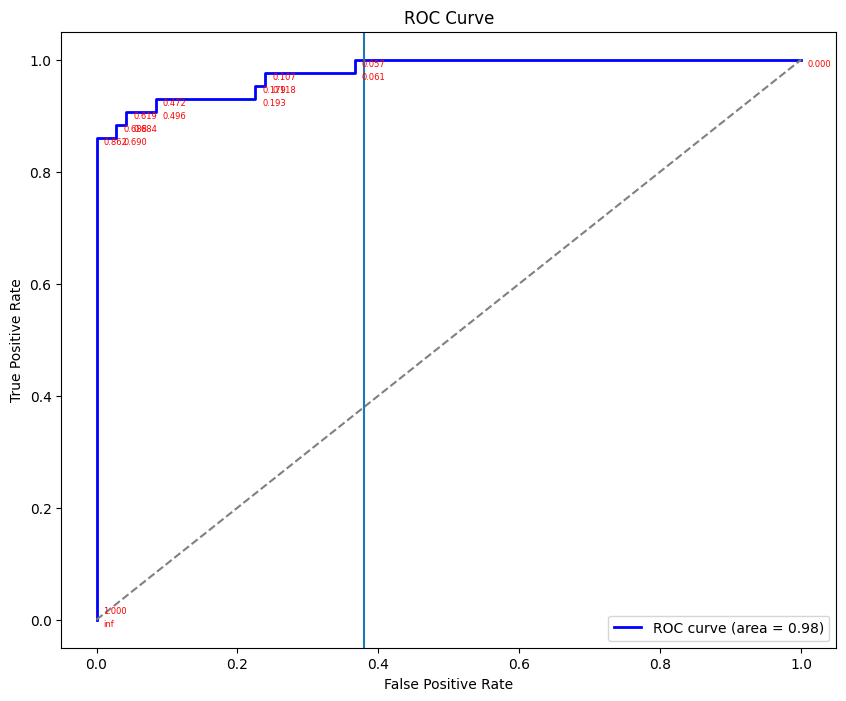

0.3802816901408451

In [152]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = lr.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_val, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

y_score = (y_score > 0.05).astype(int)
mask = Y_val == 0
FPR = 1 - (Y_val[mask] == y_score[mask]).mean()

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

for i in range(len(thresholds)):
    plt.annotate(f"{thresholds[i]:.3f}", (fpr[i], tpr[i]), 
                 textcoords="offset points", xytext=(5, -5), fontsize=6, color="red")

plt.axvline(FPR)
plt.show()
FPR

Patrząc na wykres oceaniam, że optymalny threshold wynosi 0.05 (ponieważ zakladam że fałszywe wykrycie złośliwego guza oznacza wyłącznie niepotrzebną kontrolę lekarską, której koszt jest niski).


Helper question 1:
Would a different threshold yield better results?
Obniżając threshold zwiększamy sensitivity kosztem specificity. To czy zmieniając threshold uzyskamy lepszy rezultat jest kwestią indywidualnej "wyceny" fałszywie wykrytych przypadków vs przypadków niewykrytych.

Helper question 2:
How do you define "better" results?
Obiektywnie lepszy rezultat otrzymujemy poprawiając sensitivity, bez pogorszenia specificity (lub odwrotnie). Nie jest to jednak osiągalne zmieniając threshold. 
W przypadku moich danych, żeby wybrać optymalny threshold, musimy "wycenić" niewykrycia oraz fałszywe wykrycia. Zakładam, że mój model ma sugerować, którzy pacjenci powinni udać się na kontrolę do lekarza. W tym przypadku moglibyśmy obniżyć threshold, ponieważ koszt kilku niepotrzebnych kontroli lekarskich jest niższy niż sklasyfikowania złośliwego guza jako niezłośliwy, co mogłoby doprowadzić do śmierci pacjenta.
W przypadku modelu wykrywającego spam, moglibyśmy zwiększać threshold, ponieważ koszt niewykrycia spamu jest niższy, niż usunięcia cennej wiadomości.

Helper question 3:
How does a ROC curve help in this process?
Krzywa ROC jest szczególnie przydatna, gdy nie jesteśmy w stanie jednoznacznie ocenić kosztów obu rodzaajów błędów. Obrazuje ona jaką "wymianę" zrobimy zmieniając threshold. 

Helper question 4:
How do you select the optimal threshold using the ROC curve?
Wyznaczamy koszty błędów obu rodzajów i na podstawie krzywej na każdnym "schodku" liczymy łączną wartość kosztu. Wybieramy threshold minimalizujący koszt.

Helper question 5:
What is the AUC metric and how is it useful?
Możemy używać jej do oceny jakości modelu, im wyższa wartość tym lepszy model. Szczególnie ważna może być jeśli nie znamy jeszcze kosztów.


In [154]:
y_pred = lr.predict_proba(X_test)[:, 1]
y_pred = (y_pred > 0.05).astype(int)
y_pred


array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1])

In [155]:
#accuracy:
accuracy = (y_pred == Y_test).mean()

#precision:
mask = y_pred == 1
precision = (Y_test[mask] == y_pred[mask]).mean()

#recall
mask = Y_test == 1
recall = (Y_test[mask] == y_pred[mask]).mean()

#F1 score:
F1_score = 2 * (precision * recall) / (precision + recall)

#Specificity:
mask = Y_test == 0
specificity = (Y_test[mask] == y_pred[mask]).mean()

#Sensitivity:
sensitivity = recall

print(accuracy, precision, recall, F1_score, specificity, sensitivity)

0.8421052631578947 0.7 1.0 0.8235294117647058 0.75 1.0


Oceniam działanie modelu jako dobre. U co czwartej osoby, która nie ma złośliwego guza niesłusznie przewidujemy złośliwego, ale wykrywamy wszystkie przypadki złośliwego guza.